<a href="https://www.kaggle.com/code/computingvictor/1-exploratory-data-analysis-nlp?scriptVersionId=140557257" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Exploratory Data Analysis
    
<strong>Multiclass sentiment analysis of the users</strong><br />
    
Thread app dataset: 37000 entities


<p style="text-align:right">V&iacute;ctor Viloria  (<em>ComputingVictor</em>)</p>



<hr style="border:1px solid gray">

## Structure

[Introduction](#introduccion) 

[1. Python libraries](#librerias) 

[2. Data Loading](#lectura) 

[3. Exploratory Data Analysis ](#EDA) 

   - 3.1 Shape and types
   - 3.2 Nulls
   - 3.3 Numerical Analysis
   - 3.4 Temporal Series Analysis
   
[4. Text transformation](#text) 

[5. Data export](#export) 

<hr style="border:1px solid gray">

## <a name="introduccion"> Introduction <a>

In this notebook, We will use the *Thread app dataset: 37000 entities*, we will proceed with data preprocessing for natural language processing (NLP) on reviews posted on the Threads app. Then we will train different models, MLand Neuronal networks to predict the sentiment of each review.

## <a name="librerias"> 1. Python libraries <a>


In [1]:
# Import pandas.

import pandas as pd

# Import nltk.

import nltk
nltk.download('punkt')

# Import nltk stopwords.

nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter

# Import wordcloud and matplotlib.

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## <a name="lectura"> 2. Data Loading <a>


In [2]:
# Load the csv file.

threads_df = pd.read_csv("/kaggle/input/37000-reviews-of-thread-app-dataset/37000_reviews_of_thread_app.csv",index_col=[0])

# Display the first rows.

threads_df.head(5)

,source,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,laguage_code,country_code
0,Google Play,7cd90e5b-4829-43b9-9fb4-c8c6d1e339c1,Eddie Clark Jr.,NaN,Good,5,0.0,2023-08-07 19:14:36,NaN,NaN,294.0.0.27.110,en,us
1,Google Play,6deb8265-2bac-4524-bcb6-f90829fa4e69,Rasa RT,NaN,Weak copy of Twitter,1,0.0,2023-08-07 19:07:04,NaN,NaN,NaN,en,us
2,Google Play,91ef61ce-0f05-4f3b-b3d3-5d19cd408ab8,SITI NUR HAFIZA BINTI AZIZ,NaN,i wish threads have a save button for images a...,3,0.0,2023-08-07 18:57:07,NaN,NaN,294.0.0.27.110,en,us
3,Google Play,b7721b78-6b77-4f8c-a1d3-a854af4c1f0f,Asap Khalifah,NaN,Love it,5,0.0,2023-08-07 18:37:16,NaN,NaN,NaN,en,us
4,Google Play,c89ef522-c94c-4171-878f-1d672dce7f11,Syed Hussein,NaN,Very god,5,0.0,2023-08-07 18:14:15,NaN,NaN,NaN,en,us


## <a name="EDA"> 3. Exploratory data analysis <a> 

### 3.1 Shape and types

In [3]:
# Print the shape of the dataframe.

print("The dataframe has {} rows and {} columns.".format(threads_df.shape[0], threads_df.shape[1]))

print("---------------------------------------------------------------------------------------")

# Print the column names and datatypes.

threads_df.info()

The dataframe has 36943 rows and 13 columns.
---------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 36943 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   source                   36943 non-null  object 
 1   review_id                36943 non-null  object 
 2   user_name                36943 non-null  object 
 3   review_title             2000 non-null   object 
 4   review_description       36943 non-null  object 
 5   rating                   36943 non-null  int64  
 6   thumbs_up                34943 non-null  float64
 7   review_date              36943 non-null  object 
 8   developer_response       0 non-null      float64
 9   developer_response_date  0 non-null      float64
 10  appVersion               24855 non-null  object 
 11  laguage_code             36943 non-null  object 
 12

### 3.2 Nulls

In [4]:
# Print the number of null values in each column.

threads_df.isnull().sum()

source                         0
review_id                      0
user_name                      0
review_title               34943
review_description             0
rating                         0
thumbs_up                   2000
review_date                    0
developer_response         36943
developer_response_date    36943
appVersion                 12088
laguage_code                   0
country_code                   0
dtype: int64

We notice that there are some rows with high number of null data that are irrelevant for our analysis, we proceed to drop them. For `thumbs_up` we will convert the nulls to 0.

In [5]:
# Drop the developer columns, appVersion and review_title variable.

threads_df = threads_df.drop(['review_title', 'developer_response', 'developer_response_date', 'appVersion'], axis=1)

# Convert nulls of thumbs_up to 0.

threads_df['thumbs_up'] = threads_df['thumbs_up'].fillna(0)

# Display the first rows of "threads_df".

threads_df.head(5)

,source,review_id,user_name,review_description,rating,thumbs_up,review_date,laguage_code,country_code
0,Google Play,7cd90e5b-4829-43b9-9fb4-c8c6d1e339c1,Eddie Clark Jr.,Good,5,0.0,2023-08-07 19:14:36,en,us
1,Google Play,6deb8265-2bac-4524-bcb6-f90829fa4e69,Rasa RT,Weak copy of Twitter,1,0.0,2023-08-07 19:07:04,en,us
2,Google Play,91ef61ce-0f05-4f3b-b3d3-5d19cd408ab8,SITI NUR HAFIZA BINTI AZIZ,i wish threads have a save button for images a...,3,0.0,2023-08-07 18:57:07,en,us
3,Google Play,b7721b78-6b77-4f8c-a1d3-a854af4c1f0f,Asap Khalifah,Love it,5,0.0,2023-08-07 18:37:16,en,us
4,Google Play,c89ef522-c94c-4171-878f-1d672dce7f11,Syed Hussein,Very god,5,0.0,2023-08-07 18:14:15,en,us


In [6]:
# Print the number of null values in each column.

threads_df.isnull().sum()

source                0
review_id             0
user_name             0
review_description    0
rating                0
thumbs_up             0
review_date           0
laguage_code          0
country_code          0
dtype: int64

### 3.3 Numerical Analysis

#### 3.3.1. Unique Values

First of all, we will check the unique values for the most important variables

In [7]:
# Check unique values
unique_sources = threads_df['source'].unique()
unique_ratings = threads_df['rating'].unique()
unique_languages = threads_df['laguage_code'].unique()
unique_countries = threads_df['country_code'].unique()
unique_thumbs_up = threads_df['thumbs_up'].unique()

print("Unique values for source:", unique_sources)
print("Unique values for rating:", unique_ratings)
print("Unique values for language_code:", unique_languages)
print("Unique values for country_code:", unique_countries)

Unique values for source: ['Google Play' 'App Store']
Unique values for rating: [5 1 3 2 4]
Unique values for language_code: ['en']
Unique values for country_code: ['us']


We found multiple variables in `ratings` and `source`. Let's check the number of reviews by rating.

#### 3.3.2. Number of Reviews by rating

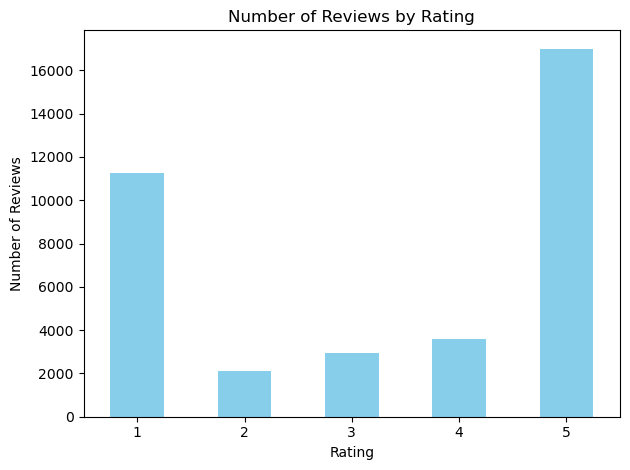

In [8]:
# Group by 'rating' and count reviews.
ratings_count = threads_df['rating'].value_counts().sort_index()

# Plot.
ratings_count.plot(kind='bar', color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews by Rating')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

As we can see, the ratings are polarized. With the 1 and 5 ratings with +10k values, while the other rating values have less data.

#### 3.3.3. Top 5 of total thumbs in the dataset

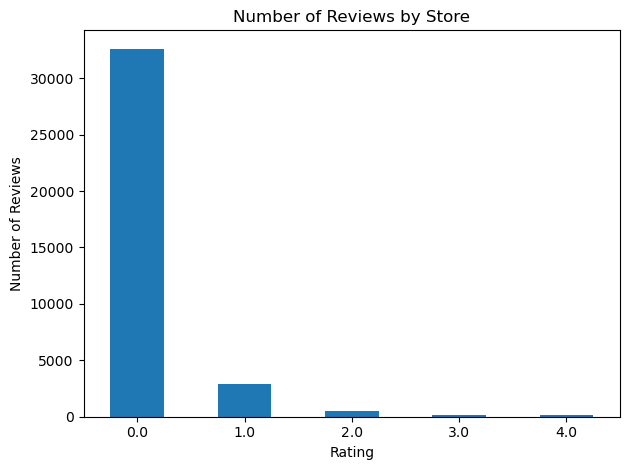

In [9]:
# Group by 'source' and count reviews.
thumbs_count = threads_df['thumbs_up'].value_counts().sort_values(ascending=False)

thumbs_count.head(5).plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews by Store')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### 3.3.4. Number of Reviews by Store

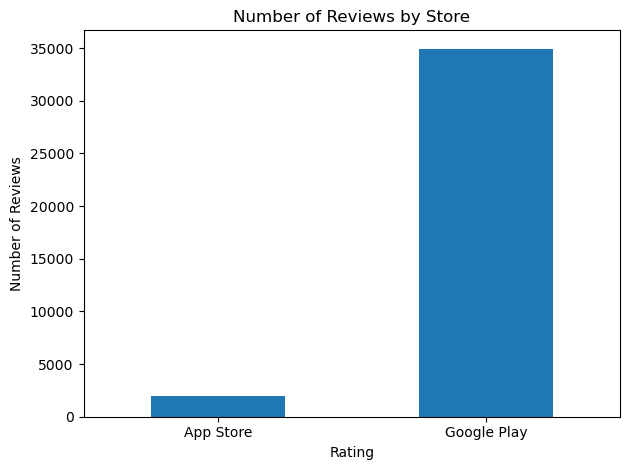

In [10]:
# Group by 'source' and count reviews.
ratings_count = threads_df['source'].value_counts().sort_index()

# Plot.
ratings_count.plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews by Store')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Most of the reviews come from Google Play.

#### 3.3.5. Users with most reviews.

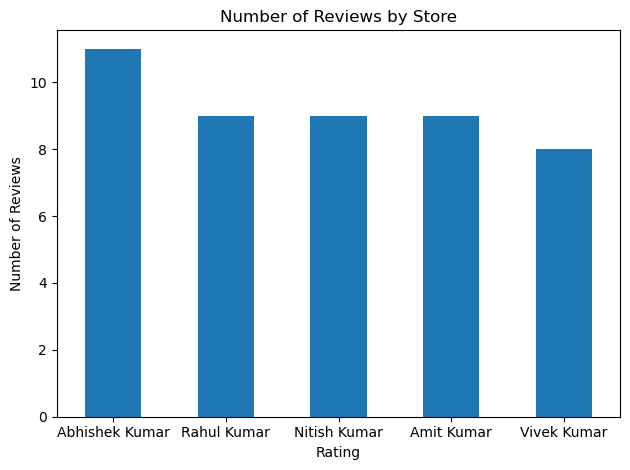

In [11]:
# Group by 'source' and count reviews.
user_count = threads_df['user_name'].value_counts().sort_values(ascending=False)

user_count.head(5).plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews by Store')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

We can see there are several people with same names or repeated accounts that reviewed more than once.

### 3.4 Temporal Series Analysis

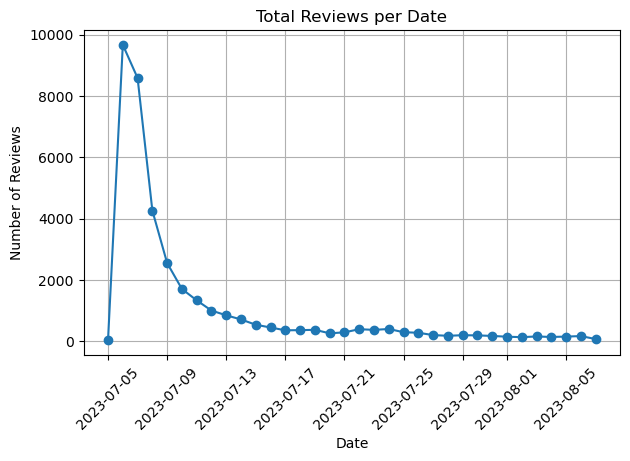

In [12]:
# Convert 'review_date' to datetime and extract only the date part.

threads_df['review_date'] = pd.to_datetime(threads_df['review_date']).dt.date

# Group by 'review_date' (only the date) and count reviews.

daily_reviews = threads_df.groupby('review_date').size()


# Plot.

daily_reviews.plot(kind='line', marker='o')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.title('Total Reviews per Date')
plt.tight_layout()
plt.grid(True)
plt.xticks(rotation=45) 
plt.subplots_adjust(bottom=0.25)  
plt.show()

In the temporal Series plot, we can check that most of the reviews came during the first days of the app release. 7 days after, the numbers of reviews dropped considerably, with August at a low

## <a name="text"> 4. Text transfomation <a>

We will make some transformations in the text with the objective to standardize it. We will convert all to lowercase, then we will remove the sign punctuations, remove the line breaks in case there would be and emoticons.

In [13]:
# Convert the text column to lowercase.

threads_df['review_description'] = threads_df['review_description'].str.lower()

# Delete emoticons with text.

threads_df['review_description'] = threads_df['review_description'].str.replace('[\:\;\=][\-\^]?[\(\)\[\]\{\}\@D\|Pp\$\*\+\#]','')

# Delete punctuation signs.

threads_df['review_description'] = threads_df['review_description'].str.replace('[^\w\s]','')

# Delete /n from text.

threads_df['review_description'] = threads_df['review_description'].str.replace('\n',' ')

/tmp/ipykernel_20/1763220278.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  threads_df['review_description'] = threads_df['review_description'].str.replace('[\:\;\=][\-\^]?[\(\)\[\]\{\}\@D\|Pp\$\*\+\#]','')
/tmp/ipykernel_20/1763220278.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  threads_df['review_description'] = threads_df['review_description'].str.replace('[^\w\s]','')


Once the transformation is done, we proceed to tokenize the text and delete the stopwords. Just to have the text ready to apply it into differents models. 

In [14]:
# Convert the reviewText column to string.

threads_df['review_description'] = threads_df['review_description'].astype(str)

# Tokenize the text.

threads_df['review_description'] = threads_df['review_description'].apply(nltk.word_tokenize)

# Delete the stopwords from text.

stop_words = set(stopwords.words('english'))

threads_df['review_description'] = threads_df['review_description'].apply(lambda x: [item for item in x if item not in stop_words])

# Convert reviewText column to string with space between words.

threads_df['review_description'] = threads_df['review_description'].apply(lambda x: ' '.join(x))

# Display first 5 rows

threads_df.head()

,source,review_id,user_name,review_description,rating,thumbs_up,review_date,laguage_code,country_code
0,Google Play,7cd90e5b-4829-43b9-9fb4-c8c6d1e339c1,Eddie Clark Jr.,good,5,0.0,2023-08-07,en,us
1,Google Play,6deb8265-2bac-4524-bcb6-f90829fa4e69,Rasa RT,weak copy twitter,1,0.0,2023-08-07,en,us
2,Google Play,91ef61ce-0f05-4f3b-b3d3-5d19cd408ab8,SITI NUR HAFIZA BINTI AZIZ,wish threads save button images videos would l...,3,0.0,2023-08-07,en,us
3,Google Play,b7721b78-6b77-4f8c-a1d3-a854af4c1f0f,Asap Khalifah,love,5,0.0,2023-08-07,en,us
4,Google Play,c89ef522-c94c-4171-878f-1d672dce7f11,Syed Hussein,god,5,0.0,2023-08-07,en,us


Let's check the wordclouds.

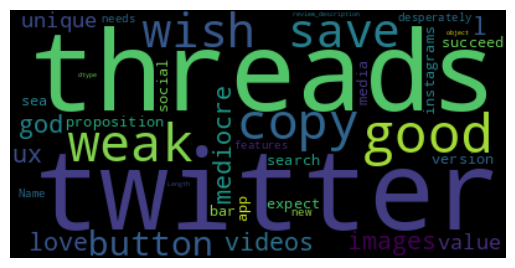

In [15]:
# Create a wordcloud of the first 100 reviews.

wordcloud = WordCloud().generate(str(threads_df['review_description']))

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")

plt.show()


The most common words are related with his competitor "Twitter" and different opinions appeared in order to the most common ratins we checked before: 1 and 5. Lets see the most used words:

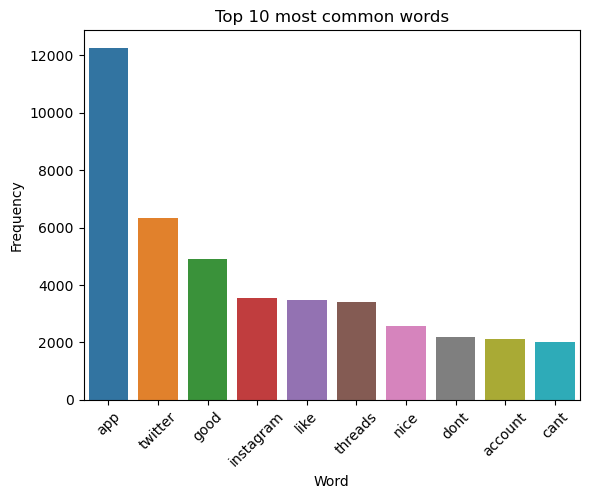

In [16]:
# Histogram of the top 10 most common words.

top_10_words = Counter(" ".join(threads_df['review_description']).split()).most_common(10)

top_10_df = pd.DataFrame(top_10_words)

top_10_df.columns=["Word", "Frequency"]

sns.barplot(x="Word", y="Frequency", data=top_10_df)

plt.title("Top 10 most common words")

plt.xlabel("Word")

plt.ylabel("Frequency")

plt.xticks(rotation=45)

plt.show()

Finally we will drop variables that won't be relevant for the training of the models.

In [17]:
# Drop irrelevant variables

threads_df = threads_df.drop(['laguage_code', 'country_code', 'review_id', 'source'], axis=1)

# Display the first rows.

threads_df.head(5)

,user_name,review_description,rating,thumbs_up,review_date
0,Eddie Clark Jr.,good,5,0.0,2023-08-07
1,Rasa RT,weak copy twitter,1,0.0,2023-08-07
2,SITI NUR HAFIZA BINTI AZIZ,wish threads save button images videos would l...,3,0.0,2023-08-07
3,Asap Khalifah,love,5,0.0,2023-08-07
4,Syed Hussein,god,5,0.0,2023-08-07


## <a name="export"> 5. Data export <a>

Once the DF has been transformed and analysed, we will export it, to proceed with the training of the ML and RNN models. It will  be published shortly.

In [18]:
# Export to a Parquet file.

threads_df.to_parquet('/kaggle/working/threads_df.parquet')